In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
import prince
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.metrics import silhouette_score

In [21]:
# Importando o banco de dados

clientes = pd.read_excel('data/clientes_segmenta.xlsx')
## Fonte: adaptado de https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation

In [22]:
# Estatísticas gerais do banco de dados

clientes.info()
## Note que há valores faltantes "nan"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         8068 non-null   object 
 1   EverMarried    7928 non-null   object 
 2   Age            8068 non-null   int64  
 3   Graduated      7990 non-null   object 
 4   SpendingScore  8068 non-null   object 
 5   FamilySize     7733 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 378.3+ KB


In [23]:
# Removendo as observações com valores faltantes

clientes.dropna(inplace=True)

# Novas informações sobre o dataset
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7538 entries, 0 to 8067
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         7538 non-null   object 
 1   EverMarried    7538 non-null   object 
 2   Age            7538 non-null   int64  
 3   Graduated      7538 non-null   object 
 4   SpendingScore  7538 non-null   object 
 5   FamilySize     7538 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 412.2+ KB


In [24]:
# Vamos iniciar realizando a clusterização nas variáveis quantitativas

# Separando somente as variáveis quantitativas do banco de dados
df_quanti = clientes[['Age', 'FamilySize']]

# Estatísticas descritivas das variáveis
df_quanti.describe()

,Age,FamilySize
count,7538.000000,7538.000000
mean,43.524144,2.845450
std,16.612202,1.527899
min,18.000000,1.000000
25%,31.000000,2.000000
50%,41.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


In [25]:
# Realizando a padronização por meio do Z-Score

# As variáveis estão em unidades de medidas distintas
df_quanti_pad = df_quanti.apply(zscore, ddof=1)

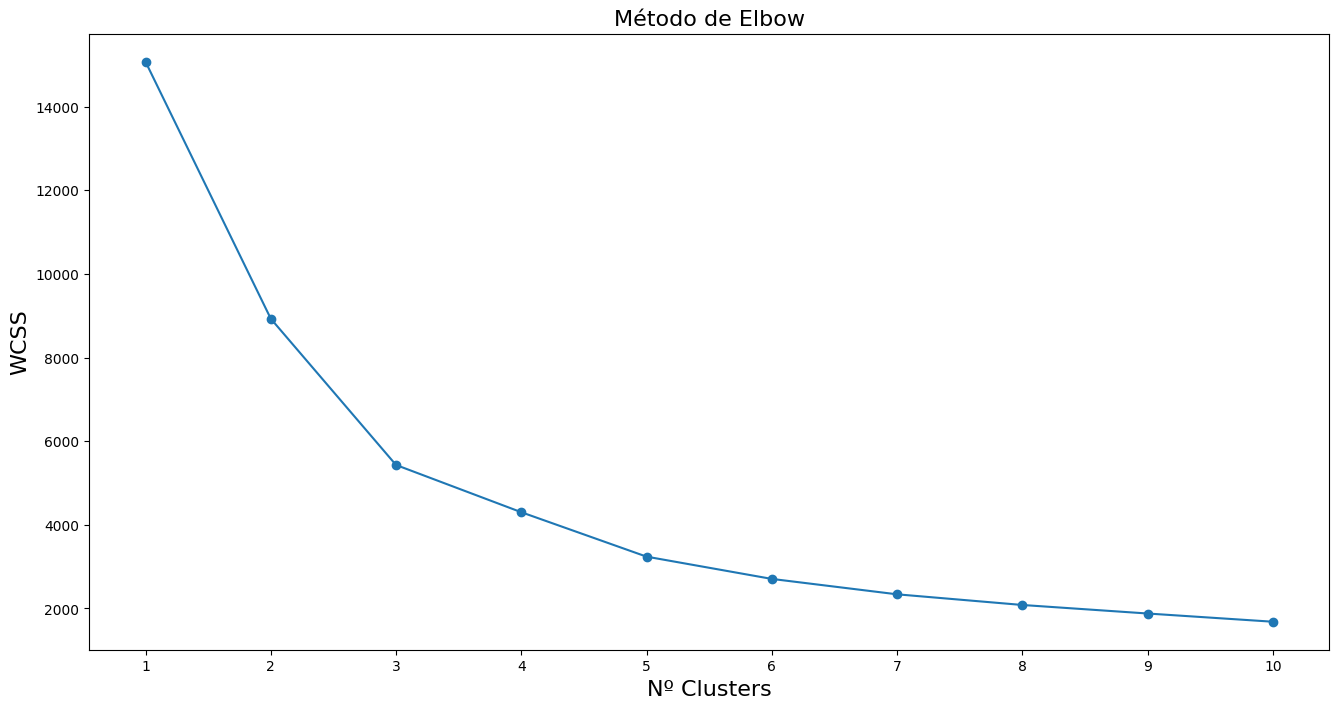

In [26]:
# Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_quanti_pad)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

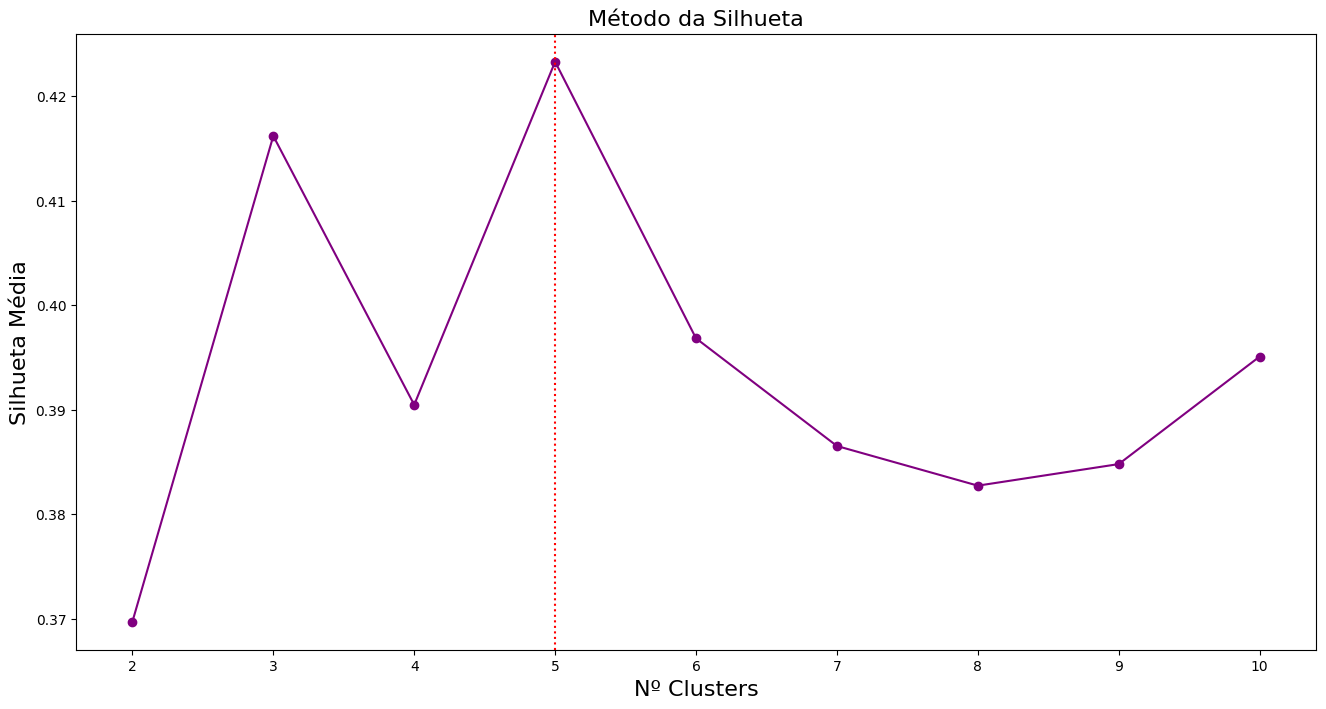

In [27]:
# Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_quanti_pad)
    silhueta.append(silhouette_score(df_quanti_pad, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

In [28]:
# Cluster K-means

# Vamos considerar 5 clusters, dadas as evidências anteriores!
kmeans_final = KMeans(n_clusters = 5, init = 'random', random_state=100).fit(df_quanti_pad)

# Gerando a variável para identificarmos os clusters gerados
kmeans_clusters = kmeans_final.labels_
clientes['Cluster'] = kmeans_clusters
df_quanti_pad['Cluster'] = kmeans_clusters
clientes['Cluster'] = clientes['Cluster'].astype('category')
df_quanti_pad['Cluster'] = df_quanti_pad['Cluster'].astype('category')

In [29]:
# ANOVA

# Analisando se as duas variáveis são significativas para a clusterização 

# Age
print(pg.anova(dv='Age', 
         between='Cluster', 
         data=df_quanti_pad,
         detailed=True).T)
# Family Size
print(pg.anova(dv='FamilySize', 
         between='Cluster', 
         data=df_quanti_pad,
         detailed=True).T)

                  0            1
Source      Cluster       Within
SS      5741.233311  1795.766689
DF                4         7533
MS      1435.308328     0.238387
F       6020.925602          NaN
p-unc           0.0          NaN
np2         0.76174          NaN
                  0           1
Source      Cluster      Within
SS       6093.24086  1443.75914
DF                4        7533
MS      1523.310215    0.191658
F       7948.068021         NaN
p-unc           0.0         NaN
np2        0.808444         NaN


In [30]:
# Quais são as características dos clusters em termos de idade e família

clientes[['Age', 'FamilySize', 'Cluster']].groupby(by=['Cluster'], observed=False).mean()

,Age,FamilySize
Cluster,,
0,30.911765,5.870844
1,70.043575,1.790990
2,38.561439,1.592158
3,28.436681,3.435434
4,51.387170,3.763774


### Integração com Anacor

In [31]:
# Vamos realizar uma ACM nas variáveis qualitativas (incluir os clusters!)

# Separando somente as variáveis categóricas do banco de dados
df_quali = clientes[['Gender', 'EverMarried', 'Graduated', 'SpendingScore', 'Cluster']]

#%% Estatísticas descritivas univariadas

# Tabelas de frequências por variável
print(df_quali.Gender.value_counts())
print(df_quali.EverMarried.value_counts())
print(df_quali.Graduated.value_counts())
print(df_quali.SpendingScore.value_counts())
print(df_quali.Cluster.value_counts())

Gender
Male      4163
Female    3375
Name: count, dtype: int64
EverMarried
Yes    4466
No     3072
Name: count, dtype: int64
Graduated
Yes    4731
No     2807
Name: count, dtype: int64
SpendingScore
Low        4504
Average    1888
High       1146
Name: count, dtype: int64
Cluster
2    2474
3    1603
1    1354
4    1325
0     782
Name: count, dtype: int64


In [32]:
# Testes qui-quadrado para pares de variáveis

# Vamos colocar como referência 'SpendingScore'

tabela1 = chi2_contingency(pd.crosstab(df_quali["SpendingScore"],
                                       df_quali["Gender"]))
print(f"p-valor da estatística: {round(tabela1[1], 4)}")

tabela2 = chi2_contingency(pd.crosstab(df_quali["SpendingScore"], 
                                       df_quali["EverMarried"]))
print(f"p-valor da estatística: {round(tabela2[1], 4)}")

tabela3 = chi2_contingency(pd.crosstab(df_quali["SpendingScore"], 
                                       df_quali["Graduated"]))
print(f"p-valor da estatística: {round(tabela3[1], 4)}")

tabela4 = chi2_contingency(pd.crosstab(df_quali["SpendingScore"], 
                                       df_quali["Cluster"]))
print(f"p-valor da estatística: {round(tabela4[1], 4)}")

# Todas apresentam associação significativa com pelo menos uma variável

p-valor da estatística: 0.0
p-valor da estatística: 0.0
p-valor da estatística: 0.0
p-valor da estatística: 0.0


In [33]:
# Elaborando a análise de correspondência múltipla

# Criando coordenadas para 3 dimensões (a seguir, verifica-se a viabilidade)
mca = prince.MCA(n_components=3).fit(df_quali)

In [34]:
# Analisando os resultados

# Análise dos autovalores
tabela_autovalores = mca.eigenvalues_summary
print(tabela_autovalores)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.442        24.55%                     24.55%
1              0.270        15.00%                     39.55%
2              0.238        13.21%                     52.76%


In [35]:
# Inércia total da análise
print(mca.total_inertia_)

1.7999999999999885


In [36]:
# Plotar apenas dimensões com inércia parcial superior à inércia total média
quant_dim = mca.J_ - mca.K_
print(mca.total_inertia_/quant_dim)

0.19999999999999873


In [37]:
# Obtendo as coordenadas-padrão das categorias das variáveis

coord_padrao = mca.column_coordinates(df_quali)/np.sqrt(mca.eigenvalues_)
print(coord_padrao)

                               0         1         2
Gender__Female         -0.236523 -0.653927 -0.737880
Gender__Male            0.191753  0.530147  0.598209
EverMarried__No        -1.601284 -0.162705 -0.041124
EverMarried__Yes        1.101465  0.111919  0.028288
Graduated__No          -0.763391  1.381075  0.861258
Graduated__Yes          0.452936 -0.819420 -0.511002
SpendingScore__Average  1.424467 -1.121419  1.835795
SpendingScore__High     1.610741  2.433804 -1.707910
SpendingScore__Low     -1.006950 -0.149178 -0.334973
Cluster__0             -1.224921  1.311033  1.123103
Cluster__1              1.163937  1.913665 -2.508373
Cluster__2             -0.259283 -1.936697 -0.950453
Cluster__3             -1.387804  0.956657  1.135373
Cluster__4              1.696630 -0.270539  2.301501


In [38]:
# Plotando o mapa perceptual (coordenadas-padrão)

# Primeiro passo: gerar um DataFrame detalhado

chart = coord_padrao.reset_index()
var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])

nome_categ=[]
for col in df_quali:
    nome_categ.append(df_quali[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'obs_z': chart[2],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

# Segundo passo: gerar o gráfico de pontos

fig = px.scatter_3d(chart_df_mca, 
                    x='obs_x', 
                    y='obs_y', 
                    z='obs_z',
                    color='variavel',
                    text=chart_df_mca.categoria_id)
fig.show()

## Clustering K-Means com Dummização

In [28]:
categorical_columns = ['Gender', 'EverMarried', 'Graduated', 'SpendingScore']

# Dummizando as variáveis categóricas
df_dummized = pd.get_dummies(clientes, columns=categorical_columns, drop_first=True, dtype='int')

In [30]:
df_dummized

,Age,FamilySize,Cluster,Gender_Male,EverMarried_Yes,Graduated_Yes,SpendingScore_High,SpendingScore_Low
0,22,4.0,3,1,0,0,0,1
1,38,3.0,3,0,1,1,0,0
2,67,1.0,1,0,1,1,0,1
3,67,2.0,1,1,1,1,1,0
4,40,6.0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
8063,22,7.0,0,1,0,0,0,1
8064,35,4.0,3,1,0,0,0,1
8065,33,1.0,2,0,0,1,0,1
8066,27,4.0,3,0,0,1,0,1


In [36]:
df_dummized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7538 entries, 0 to 8067
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 7538 non-null   int64   
 1   FamilySize          7538 non-null   float64 
 2   Cluster             7538 non-null   category
 3   Gender_Male         7538 non-null   int64   
 4   EverMarried_Yes     7538 non-null   int64   
 5   Graduated_Yes       7538 non-null   int64   
 6   SpendingScore_High  7538 non-null   int64   
 7   SpendingScore_Low   7538 non-null   int64   
dtypes: category(1), float64(1), int64(6)
memory usage: 736.7 KB


In [37]:
# Realizando a padronização por meio do Z-Score

# As variáveis estão em unidades de medidas distintas
df_dummized = df_dummized.drop(columns='Cluster').apply(zscore, ddof=1)

In [38]:
df_dummized.head()

,Age,FamilySize,Gender_Male,EverMarried_Yes,Graduated_Yes,SpendingScore_High,SpendingScore_Low
0,-1.295683,0.755646,0.900337,-1.205646,-1.298155,-0.423394,0.820691
1,-0.332535,0.101152,-1.110548,0.829321,0.770222,-0.423394,-1.218323
2,1.413169,-1.207835,-1.110548,0.829321,0.770222,-0.423394,0.820691
3,1.413169,-0.553341,0.900337,0.829321,0.770222,2.361551,-1.218323
4,-0.212142,2.064632,-1.110548,0.829321,0.770222,2.361551,-1.218323


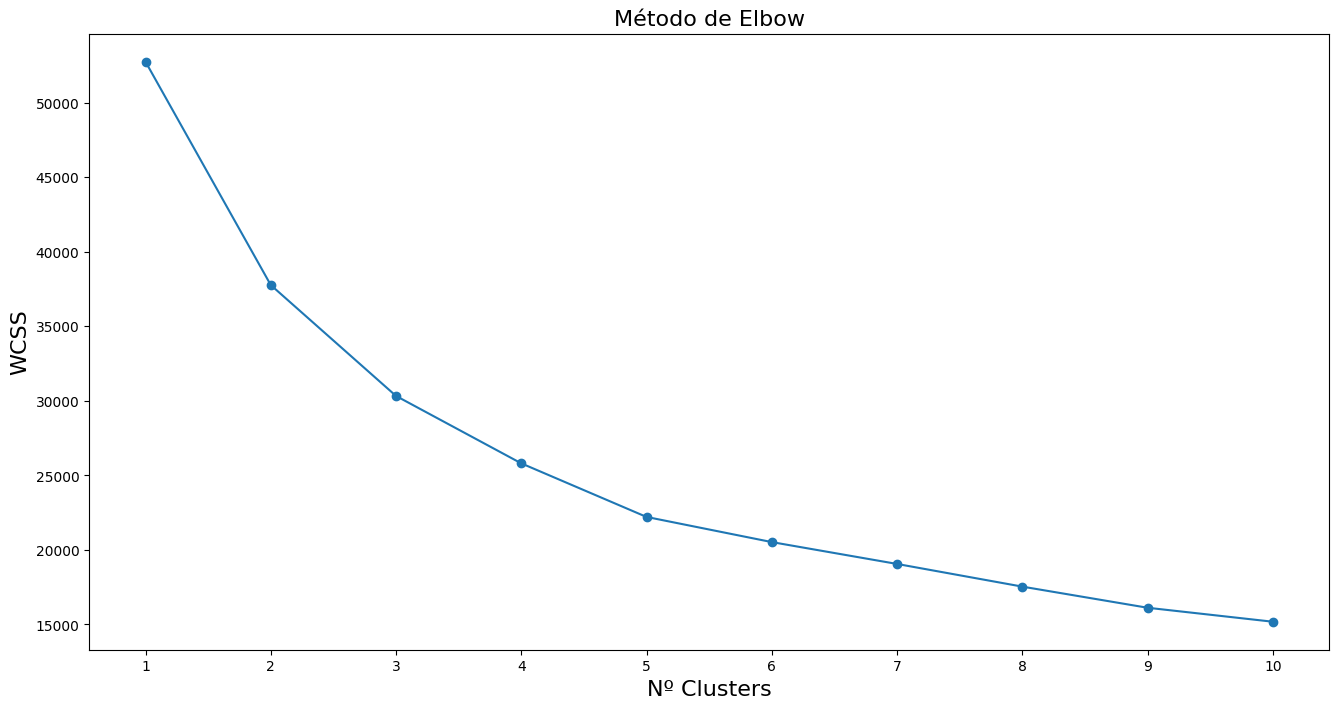

In [40]:
# Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_dummized)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

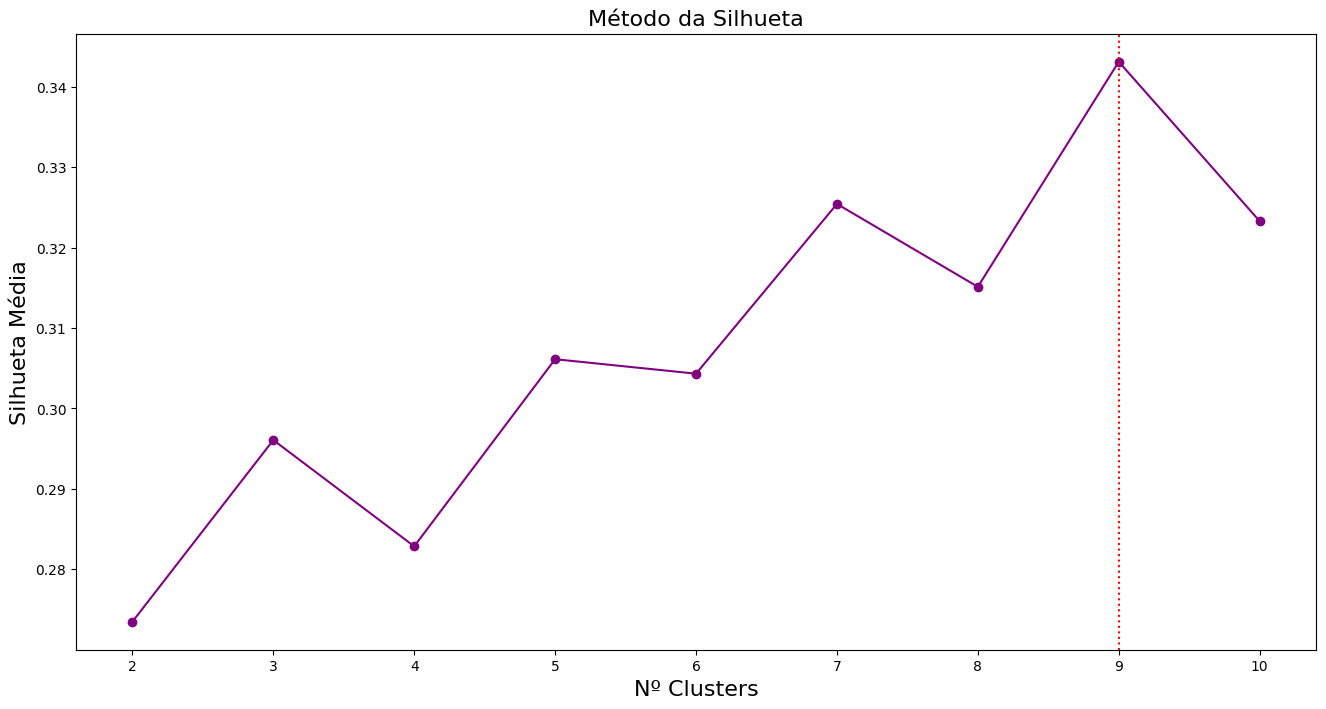

In [41]:
# Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_dummized)
    silhueta.append(silhouette_score(df_dummized, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

In [47]:
# Cluster K-means

# Vamos considerar 5 clusters, dadas as evidências anteriores!
kmeans_final = KMeans(n_clusters = 5, init = 'random', random_state=100).fit(df_dummized)

# Gerando a variável para identificarmos os clusters gerados
kmeans_clusters = kmeans_final.labels_
clientes['Cluster'] = kmeans_clusters
clientes['Cluster'] = clientes['Cluster'].astype('category')
df_dummized['Cluster'] = kmeans_clusters
df_dummized['Cluster'] = df_dummized['Cluster'].astype('category')

In [48]:
for col in df_dummized.drop(columns='Cluster').columns:
    print(col)
    display(
        pg.anova(dv=col, 
        between='Cluster', 
        data=df_dummized,
        detailed=True).T
    )

Age


,0,1
Source,Cluster,Within
SS,3285.96269,4251.03731
DF,4,7533
MS,821.490672,0.564322
F,1455.712755,NaN
p-unc,0.0,NaN
np2,0.435978,NaN


FamilySize


,0,1
Source,Cluster,Within
SS,2186.923932,5350.076068
DF,4,7533
MS,546.730983,0.710219
F,769.806717,NaN
p-unc,0.0,NaN
np2,0.290158,NaN


Gender_Male


,0,1
Source,Cluster,Within
SS,202.444668,7334.555332
DF,4,7533
MS,50.611167,0.973657
F,51.980509,NaN
p-unc,0.0,NaN
np2,0.02686,NaN


EverMarried_Yes


,0,1
Source,Cluster,Within
SS,7179.934142,357.065858
DF,4,7533
MS,1794.983535,0.0474
F,37868.675068,NaN
p-unc,0.0,NaN
np2,0.952625,NaN


Graduated_Yes


,0,1
Source,Cluster,Within
SS,2637.409748,4899.590252
DF,4,7533
MS,659.352437,0.650417
F,1013.738222,NaN
p-unc,0.0,NaN
np2,0.349928,NaN


SpendingScore_High


,0,1
Source,Cluster,Within
SS,7537.0,0.0
DF,4,7533
MS,1884.25,0.0
F,61523097105353256534040506814955520.0,NaN
p-unc,0.0,NaN
np2,1.0,NaN


SpendingScore_Low


,0,1
Source,Cluster,Within
SS,7516.242803,20.757197
DF,4,7533
MS,1879.060701,0.002756
F,681930.424454,NaN
p-unc,0.0,NaN
np2,0.997246,NaN


In [51]:
clientes.head()

,Gender,EverMarried,Age,Graduated,SpendingScore,FamilySize,Cluster
0,Male,No,22,No,Low,4.0,0
1,Female,Yes,38,Yes,Average,3.0,4
2,Female,Yes,67,Yes,Low,1.0,1
3,Male,Yes,67,Yes,High,2.0,3
4,Female,Yes,40,Yes,High,6.0,3


In [62]:
for cluster in clientes.Cluster.unique():
    print(f"Cluster: {cluster}")
    display(clientes[clientes.Cluster == cluster].describe())

Cluster: 0


,Age,FamilySize
count,1526.000000,1526.000000
mean,26.252294,4.155308
std,6.689648,1.592645
min,18.000000,1.000000
25%,21.000000,3.000000
50%,26.000000,4.000000
75%,31.000000,5.000000
max,70.000000,9.000000


Cluster: 4


,Age,FamilySize
count,1889.000000,1889.000000
mean,46.798835,3.096877
std,11.226566,1.226316
min,20.000000,1.000000
25%,38.000000,2.000000
50%,46.000000,3.000000
75%,53.000000,4.000000
max,89.000000,9.000000


Cluster: 1


,Age,FamilySize
count,1373.000000,1373.000000
mean,53.055353,1.926438
std,16.237078,1.030713
min,25.000000,1.000000
25%,40.000000,1.000000
50%,50.000000,2.000000
75%,65.000000,2.000000
max,89.000000,7.000000


Cluster: 3


,Age,FamilySize
count,1146.000000,1146.000000
mean,58.214660,2.990401
std,17.458202,1.344208
min,18.000000,1.000000
25%,43.000000,2.000000
50%,58.000000,2.000000
75%,72.000000,4.000000
max,89.000000,9.000000


Cluster: 2


,Age,FamilySize
count,1604.000000,1604.000000
mean,37.445137,1.986284
std,9.872429,1.186243
min,18.000000,1.000000
25%,30.000000,1.000000
50%,36.000000,1.000000
75%,42.000000,3.000000
max,89.000000,5.000000


In [67]:
clientes.groupby(by=['Cluster'], observed=False).agg(
    {
        'Age': ['mean', 'median', 'max', 'min', 'count'],
        'FamilySize': ['mean', 'median', 'max', 'min', 'count'],
    }
).T

Cluster                      0            1            2            3  \
Age        mean      38.561439    70.043575    28.436681    51.387170   
           median    39.000000    69.000000    28.000000    50.000000   
           max       53.000000    89.000000    40.000000    85.000000   
           min       18.000000    55.000000    18.000000    40.000000   
           count   2474.000000  1354.000000  1603.000000  1325.000000   
FamilySize mean       1.592158     1.790990     3.435434     3.763774   
           median     2.000000     2.000000     3.000000     4.000000   
           max        2.000000     4.000000     4.000000     7.000000   
           min        1.000000     1.000000     2.000000     3.000000   
           count   2474.000000  1354.000000  1603.000000  1325.000000   

Cluster                     4  
Age        mean     30.911765  
           median   29.000000  
           max      69.000000  
           min      18.000000  
           count   782.000000  
FamilySize mean      5.870844  
           median    5.000000  
           max       9.000000  
           min       5.000000  
           count   782.000000

In [68]:
clientes.groupby(by=['Cluster'], observed=False).agg(
    {
        'Gender':'value_counts',
        'EverMarried':'value_counts',
        'Graduated':'value_counts',
        'SpendingScore':'value_counts',
    }
)

Gender  EverMarried  Graduated  SpendingScore
Cluster                                                       
0       Female   1291.0          NaN        NaN            NaN
        Male     1183.0          NaN        NaN            NaN
1       Male      796.0          NaN        NaN            NaN
        Female    558.0          NaN        NaN            NaN
2       Male      931.0          NaN        NaN            NaN
        Female    672.0          NaN        NaN            NaN
3       Male      827.0          NaN        NaN            NaN
        Female    498.0          NaN        NaN            NaN
4       Male      426.0          NaN        NaN            NaN
        Female    356.0          NaN        NaN            NaN
0       Yes         NaN       1312.0     1909.0            NaN
        No          NaN       1162.0      565.0            NaN
1       Yes         NaN       1255.0      925.0            NaN
        No          NaN         99.0      429.0            NaN
2       No          NaN       1184.0      972.0            NaN
        Yes         NaN        419.0      631.0            NaN
3       Yes         NaN       1237.0      988.0            NaN
        No          NaN         88.0      337.0            NaN
4       No          NaN        539.0      504.0            NaN
        Yes         NaN        243.0      278.0            NaN
0       Low         NaN          NaN        NaN         1753.0
        Average     NaN          NaN        NaN          598.0
        High        NaN          NaN        NaN          123.0
1       Low         NaN          NaN        NaN          598.0
        High        NaN          NaN        NaN          514.0
        Average     NaN          NaN        NaN          242.0
2       Low         NaN          NaN        NaN         1284.0
        Average     NaN          NaN        NaN          220.0
        High        NaN          NaN        NaN           99.0
3       Average     NaN          NaN        NaN          708.0
        High        NaN          NaN        NaN          336.0
        Low         NaN          NaN        NaN          281.0
4       Low         NaN          NaN        NaN          588.0
        Average     NaN          NaN        NaN          120.0
        High        NaN          NaN        NaN           74.0